In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!python --version

Python 3.11.11


In [3]:
!pip install segmentation-models-pytorch torch torchvision
!pip install -qqq torchmetrics
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10

## Importing Libraries

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob

import gc
import time

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchmetrics

from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from IPython.display import Image
from skimage import io

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

from pprint import pprint

from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

from PIL import Image

import torchvision
from torchvision import transforms

In [5]:
input_data_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'
input_data = pd.read_csv(input_data_path)

In [6]:
input_data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [7]:
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [8]:
data_path = []
for sub_dir_path in glob.glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/'+'*'):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            mask_path = sub_dir_path + '/' + filename
            data_path.extend([dir_name, mask_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [9]:
filenames = data_path[::2]
masks = data_path[1::2]

In [10]:
df = pd.DataFrame(data={'patient_id': filenames, 'img_path':masks})
print(df.shape)

(7858, 2)


In [11]:
df.head()

,patient_id,img_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


Seperate rows on whether the 'img_path' column contains the word "mask" or not.

In [12]:
df['img_path'] = df['img_path'].astype(str)

original_img = df[~df['img_path'].str.contains("mask")]
mask_img = df[df['img_path'].str.contains("mask")]

#Check your answer
print(f"Number of original images; {len(original_img)}.")
print(f"Number of mask images: {len(mask_img)}.")

Number of original images; 3929.
Number of mask images: 3929.


In [13]:
imgs = sorted(original_img['img_path'].values, key=lambda x: int(x[89:-4]))
masks = sorted(mask_img['img_path'].values, key = lambda x: int(x[89:-9]))

#Sorting Check
idx = random.randint(0, len(imgs)-1)
print(f'Image path: {imgs[idx]}.  \nMask path: {masks[idx]}.')

Image path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_15.tif.  
Mask path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_15_mask.tif.


In [14]:
mri_df = pd.DataFrame({'patient_id': original_img.patient_id.values, "img_path": imgs, 'mask_path':masks})

mri_df.head()

,patient_id,img_path,mask_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [15]:
#If the masked image is all black, value = 0 i.e. there's no tumor or anything
def get_diagnosis(img_path):
    value = np.max(cv2.imread(img_path))
    if value >0:
        return 1
    else:
        return 0

In [16]:
mri_df['mask'] = mri_df['mask_path'].apply(lambda x: get_diagnosis(x))
mri_df['mask_path'] = mri_df['mask_path'].apply(lambda x: str(x))

print(mri_df.shape)

(3929, 4)


In [17]:
mri_df.head()

,patient_id,img_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [18]:
mri_df.drop(columns=['patient_id'], inplace=True)

## Exploratory Data Analysis

<Axes: title={'center': 'Count of Tumour vs No Tumour'}, xlabel='mask'>

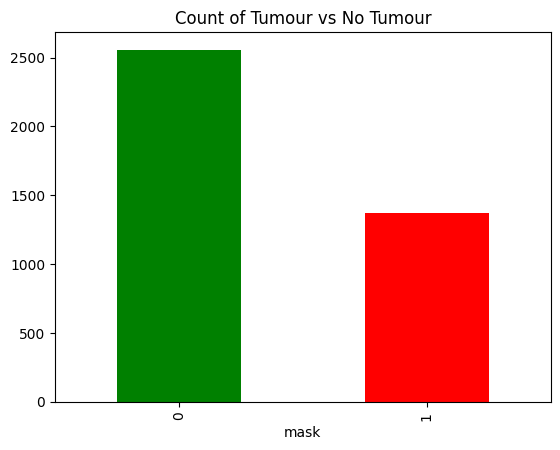

In [19]:
mri_df['mask'].value_counts().plot(kind='bar',color=['g','r'],
                title='Count of Tumour vs No Tumour')

In [20]:
mri_df['mask'].value_counts()

mask
0    2556
1    1373
Name: count, dtype: int64

Visualizing the MRI with Tumor

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


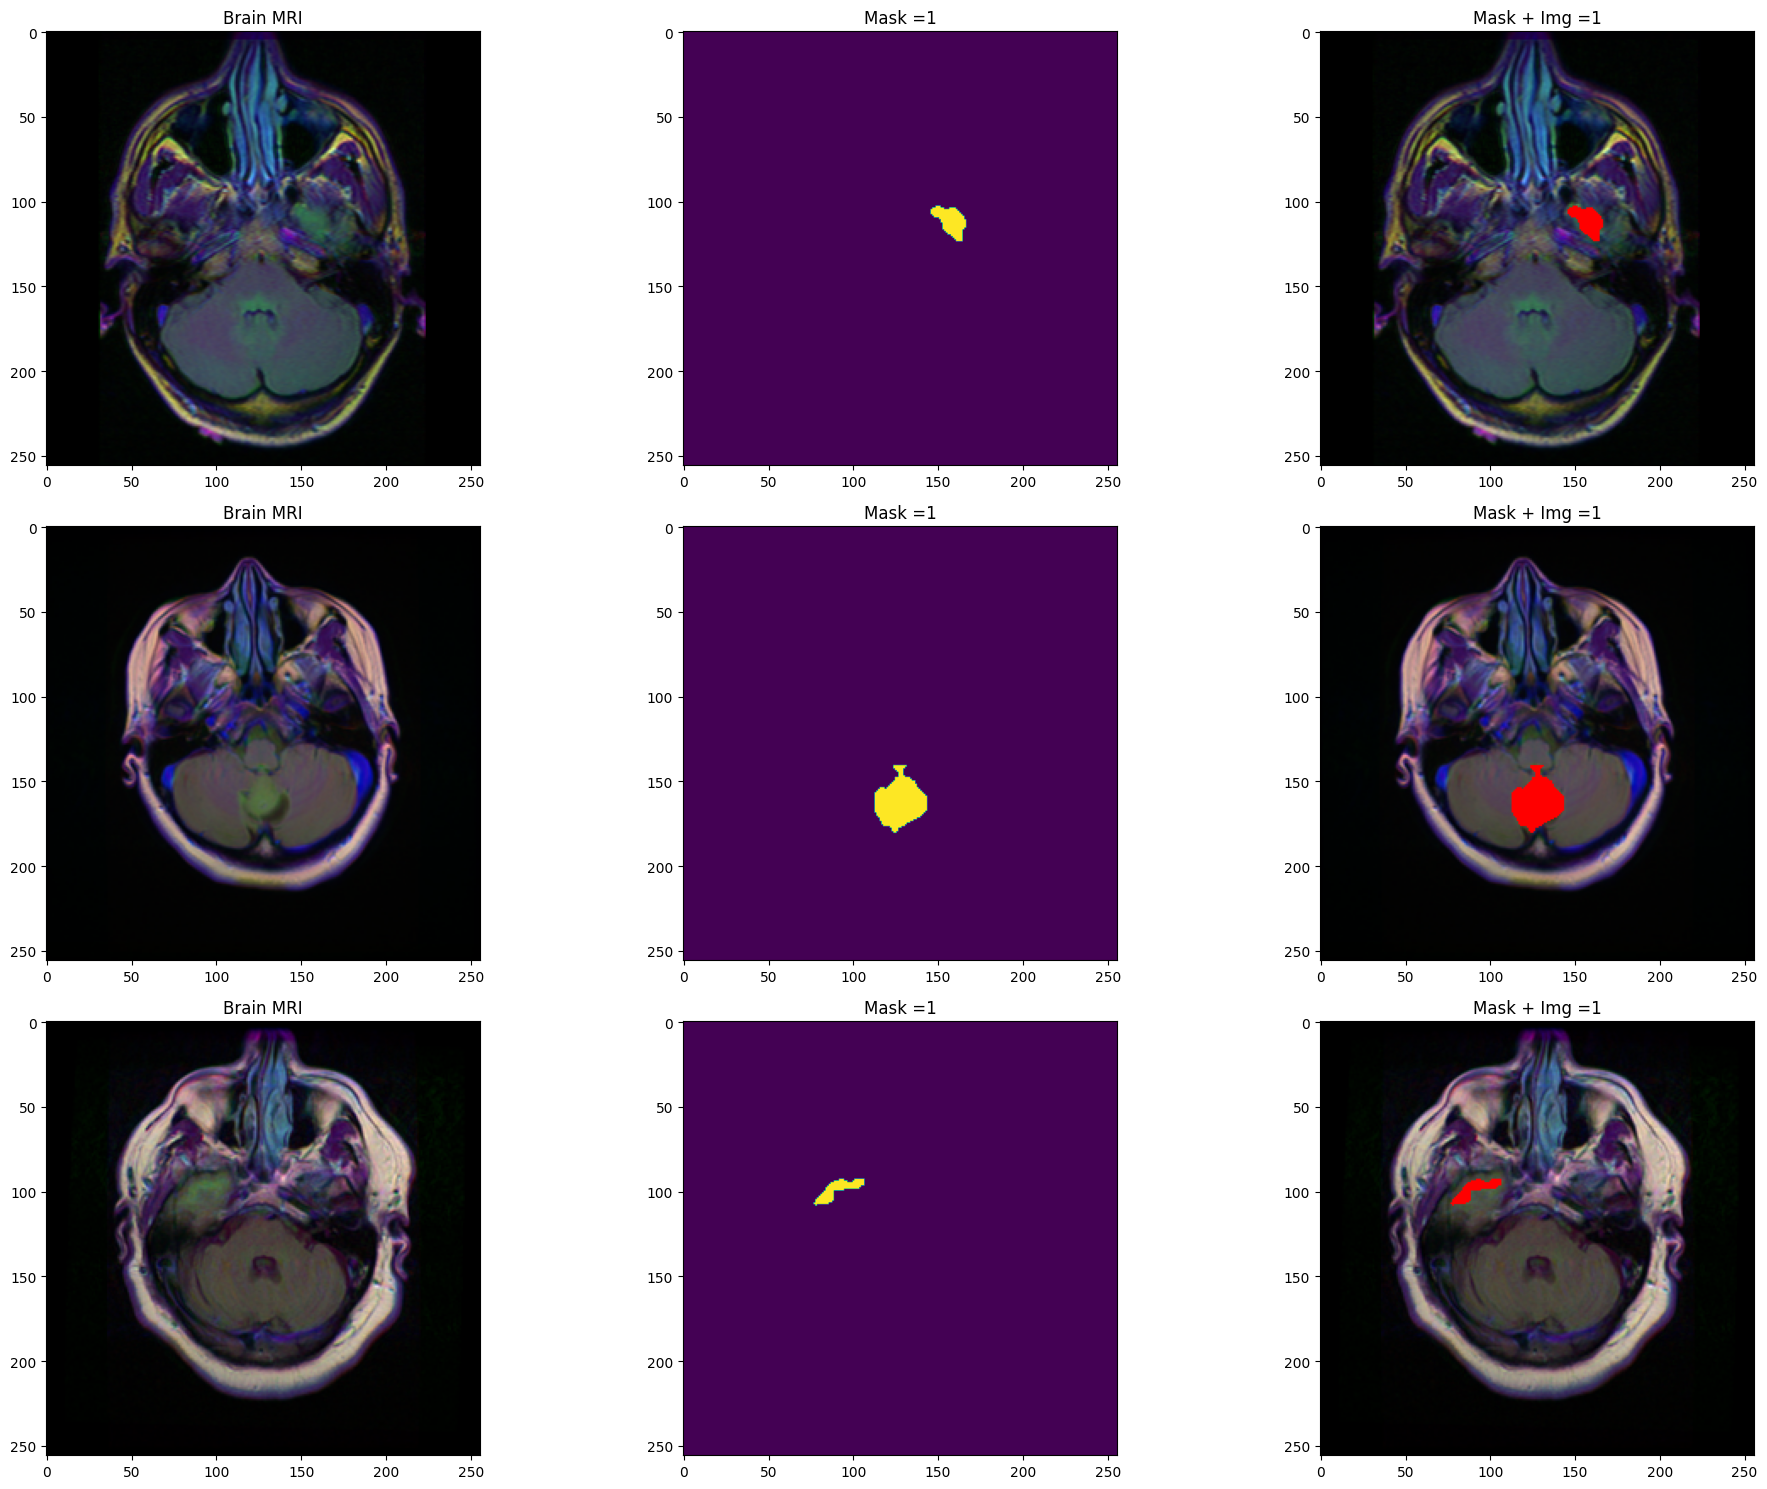

In [21]:
count = 0
i = 0
fig, axs = plt.subplots(3, 3, figsize=(20,15))
for mask in mri_df['mask']:
    if mask == 1:
        img = io.imread(mri_df.img_path[i])
        print(img.shape)
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        mask = io.imread(mri_df.mask_path[i])
        axs[count][1].title.set_text("Mask =" + str(mri_df['mask'][i]))
        axs[count][1].imshow(mask)

        img[mask ==255] = (255,0,0)
        axs[count][2].title.set_text("Mask + Img =" + str(mri_df['mask'][i]))
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==3):
        break

fig.tight_layout()
        

## Prepare dataloaders

In [22]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

## Dataset

In [23]:
def adjust_data(img, mask):
    img = img/ 255
    mask = mask/ 255
    mask[mask > 0.5] = 1.0
    mask[mask <= 0.5] = 0.0
    return img, mask

In [24]:
class MyDataset:
    def __init__(self, df=mri_df,
                adjust_data=adjust_data,
                image_transform=image_transform,
                mask_transform=mask_transform):
        self.df = df
        self.adjust_data = adjust_data
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = row['img_path']
        mask_path = row['mask_path']
    
        # Load image as RGB
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        # ✅ Load mask as GRAYSCALE (1 channel only!)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
        # Normalize and binarize
        image, mask = self.adjust_data(image, mask)
    
        # Apply transforms
        if self.image_transform:
            image = self.image_transform(image).float()
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

Sample from Dataset

In [25]:
index = 411
data = MyDataset()[index]
data[0].shape, data[1].shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

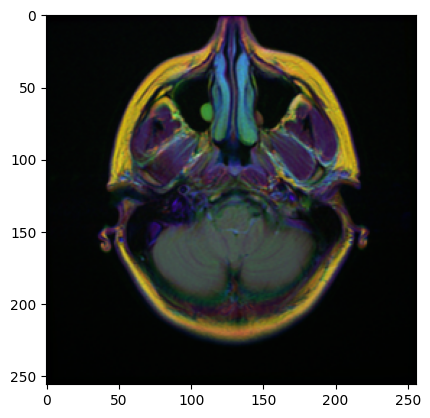

In [26]:
plt.imshow(data[0].permute(1, 2, 0).numpy())

## Dataloader

In [28]:
def prepare_loaders(df= mri_df,
                    train_num= int(mri_df.shape[0] * .6), 
                    valid_num= int(mri_df.shape[0] * .8), 
                    bs = 32):
    
    train = df[:train_num].reset_index(drop=True)
    valid = df[train_num : valid_num].reset_index(drop=True)    
    test  = df[valid_num:].reset_index(drop=True)

    train_ds = MyDataset(df = train)
    valid_ds = MyDataset(df = valid)
    test_ds = MyDataset(df = test)

    train_loader = DataLoader(train_ds, batch_size = bs, num_workers = os.cpu_count(), shuffle = True)
    valid_loader = DataLoader(valid_ds, batch_size = bs, num_workers = os.cpu_count(), shuffle = False)
    test_loader = DataLoader(test_ds, batch_size = 4, num_workers = os.cpu_count(), shuffle = True)
    
    print("DataLoader Completed")
    
    return train_loader, valid_loader, test_loader

In [29]:
train_loader, valid_loader, test_loader = prepare_loaders(df= mri_df,
                                                            train_num= int(mri_df.shape[0] * .65), 
                                                            valid_num= int(mri_df.shape[0] * .85), 
                                                            bs = 32)

DataLoader Completed


In [30]:
data = next(iter(train_loader))
data[0].shape, data[1].shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 256, 256]))

## Building the U-Net Architecture

In [31]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [32]:
class Block(nn.Module):
    def __init__(self, inputs=3, middles=64, outs=64):
        super().__init__()

        self.conv1 = nn.Conv2d(inputs, middles, 3, 1, 1)
        self.conv2 = nn.Conv2d(middles, outs, 3, 1, 1)
        self.relu = nn.ReLU()
        self.bn  = nn.BatchNorm2d(outs)
        self.pool = nn.MaxPool2d(2,2)

    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.bn(self.conv2(x)))

        return self.pool(x), x

In [33]:
class UNet(nn.Module):
    def __init__(self,):
        super().__init__()

        self.en1 = Block(3, 64, 64)
        self.en2 = Block(64, 128, 128)
        self.en3 = Block(128, 256, 256)
        self.en4 = Block(256, 512, 512)
        self.en5 = Block(512, 1024, 512)
        
        self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride = 2)
        self.de4 = Block(1024, 512, 256)
        
        self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride = 2)
        self.de3 = Block(512, 256, 128)
        
        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride = 2)
        self.de2 = Block(256, 128, 64)
        
        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        self.de1 = Block(128, 64, 64)
        
        self.conv_last = nn.Conv2d(64, 1, kernel_size=1, stride = 1, padding = 0)
    def forward(self, x):
        # x: [bs, 3, 256, 256]
        
        x, e1 = self.en1(x)
        # x: [bs, 64, 128, 128]
        # e1: [bs, 64, 256, 256]
        
        x, e2 = self.en2(x)
        # x: [bs, 128, 64, 64]
        # e2: [bs, 128, 128, 128]
        
        x, e3 = self.en3(x)
        # x: [bs, 256, 32, 32]
        # e3: [bs, 256, 64, 64]
        
        x, e4 = self.en4(x)
        # x: [bs, 512, 16, 16]
        # e4: [bs, 512, 32, 32]
        
        _, x = self.en5(x)
        # x: [bs, 512, 16, 16]
        
        x = self.upsample4(x)
        # x: [bs, 512, 32, 32]
        x = torch.cat([x, e4], dim=1)
        # x: [bs, 1024, 32, 32]
        _,  x = self.de4(x)
        # x: [bs, 256, 32, 32]
        
        x = self.upsample3(x)
        # x: [bs, 256, 64, 64]
        x = torch.cat([x, e3], dim=1)
        # x: [bs, 512, 64, 64]
        _, x = self.de3(x)
        # x: [bs, 128, 64, 64]
        
        x = self.upsample2(x)
        # x: [bs, 128, 128, 128]
        x = torch.cat([x, e2], dim=1)
        # x: [bs, 256, 128, 128]
        _, x = self.de2(x)
        # x: [bs, 64, 128, 128]
        
        x = self.upsample1(x)
        # x: [bs, 64, 256, 256]
        x = torch.cat([x, e1], dim=1)
        # x: [bs, 128, 256,256, 256
        _, x = self.de1(x)
        # x: [bs, 64, 256, 256]
        
        x = self.conv_last(x)
        # x: [bs, 1, 256, 256]
        
        # x = x.squeeze(1)         
        return x


In [34]:
model = UNet().to(device)
model

UNet(
  (en1): Block(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (en2): Block(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (en3): Block(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(256, eps=1e-05, momentum

Loss Function and Optimizer

In [35]:
# loss_fn = nn.BCELoss().to(device)
loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = torch.optim.Adam(model.parameters(), )

In [36]:
# Scheduler
from torch.optim import lr_scheduler

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max = 200,eta_min = 1e-6)

## Train one epoch

In [37]:
def train_one_epoch(model = model, 
                    dataloader = train_loader, 
                    loss_fn = loss_fn, 
                    optimizer = optimizer,
                    scheduler = None,
                    device = device, 
                    epoch = 1):
    model.train() 
    train_loss, dataset_size = 0,  0
    
    bar = tqdm(dataloader, total = len(dataloader))
    tp_l, fp_l, fn_l, tn_l = [], [], [], []
    
    for data in bar:
        x = data[0].to(device)     
        y_true = data[1].to(device) 
        y_pred = model(x)          
        
        loss = loss_fn(y_pred, y_true)
        
        pred_mask = (y_pred > 0.5).float()
        btp, bfp, bfn, btn = smp.metrics.get_stats(pred_mask.long(), y_true.long(), mode="binary")

        # 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()
        
        # train_epoch_loss
        # why? tqdm 
        bs = x.shape[0]
        dataset_size += bs
        train_loss += (loss.item() * bs)
        train_epoch_loss = train_loss / dataset_size
        
        tp_l.append(btp)
        fp_l.append(bfp)
        fn_l.append(bfn)
        tn_l.append(btn)
        
        tp = torch.cat(tp_l)
        fp = torch.cat(fp_l)
        fn = torch.cat(fn_l)
        tn = torch.cat(tn_l)
        
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
        
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        
        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        bar.set_description(f"EP:{epoch} | TL:{train_epoch_loss:.3e} | ACC: {accuracy:.2f} | F1: {f1_score:.3f} ")
        
    metrics =  dict()
    
    metrics['f1_score'] = f1_score.detach().cpu().item()
    metrics['accuracy'] = accuracy.detach().cpu().item()
    
    metrics['recall'] = recall.detach().cpu().item()
    metrics['precision'] = precision.detach().cpu().item()
    
    metrics['dataset_iou'] = dataset_iou.detach().cpu().item()
    metrics['per_iou'] = per_image_iou.detach().cpu().item()
    
    metrics['loss'] = train_epoch_loss

    return metrics

## Validate One Epoch

In [38]:
@torch.no_grad()
def valid_one_epoch(model = model, 
                    dataloader = valid_loader, 
                    loss_fn = loss_fn,
                    device = device, 
                    epoch = 0):
    model.eval() 
    valid_loss, dataset_size = 0,  0
    bar = tqdm(dataloader, total = len(dataloader))
    tp_l, fp_l, fn_l, tn_l = [], [], [], []
    
    with torch.no_grad():
        for data in bar:
            x = data[0].to(device)     
            y_true = data[1].to(device) 
            y_pred = model(x)        
            loss = loss_fn(y_pred, y_true)
            
            pred_mask = (y_pred > 0.5).float()
            btp, bfp, bfn, btn = smp.metrics.get_stats(pred_mask.long(), y_true.long(), mode="binary")

            tp_l.append(btp)
            fp_l.append(bfp)
            fn_l.append(bfn)
            tn_l.append(btn)

            tp = torch.cat(tp_l)
            fp = torch.cat(fp_l)
            fn = torch.cat(fn_l)
            tn = torch.cat(tn_l)

            recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
            precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")

            f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
            accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")

            # per image IoU means that we first calculate IoU score for each image 
            # and then compute mean over these scores
            per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

            # dataset IoU means that we aggregate intersection and union over whole dataset
            # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
            # in this particular case will not be much, however for dataset 
            # with "empty" images (images without target class) a large gap could be observed. 
            # Empty images influence a lot on per_image_iou and much less on dataset_iou.
            dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

            # valid_epoch_loss 
            bs = x.shape[0]
            dataset_size += bs
            valid_loss += (loss.item() * bs)
            valid_epoch_loss = valid_loss / dataset_size

            bar.set_description(f"EP:{epoch} | VL:{valid_epoch_loss:.3e} | ACC: {accuracy:.2f} | F1: {f1_score:.3f} ")

    metrics =  dict()
    
    metrics['f1_score'] = f1_score.detach().cpu().item()
    metrics['accuracy'] = accuracy.detach().cpu().item()
    
    metrics['recall'] = recall.detach().cpu().item()
    metrics['precision'] = precision.detach().cpu().item()
    
    metrics['dataset_iou'] = dataset_iou.detach().cpu().item()
    metrics['per_iou'] = per_image_iou.detach().cpu().item()
    
    metrics['loss'] = valid_epoch_loss

    return metrics


## Model Training

In [39]:
import copy

def run_training(model = model, 
                 loss_fn = loss_fn, 
                 train_loader = train_loader,
                 valid_loader = valid_loader,
                 optimizer = optimizer, 
                 device = device, 
                 n_epochs=100, 
                 early_stop = 20,
                 scheduler = None):

    if torch.cuda.is_available():
        print("INFO: GPU - {}\n".format(torch.cuda.get_device_name()))
    
    best_model_wts = copy.deepcopy(model.state_dict())

    lowest_epoch, lowest_loss = np.inf, np.inf
    
    train_history, valid_history = [],  []
    train_recalls, valid_recalls = [],  []
    
    train_pres, valid_pres = [],  []
    train_accs, valid_accs = [],  []
    
    train_f1s, valid_f1s = [],  []
    
    train_per_ious, valid_per_ious = [], []
    train_dataset_ious, valid_dataset_ious = [], []
    
    print_iter = 5

    best_score = 0
    best_model = "None"

    for epoch in range(0, n_epochs):
        gc.collect()

        train_metrics = train_one_epoch(model= model,
                                       dataloader = train_loader,
                                       optimizer = optimizer,
                                       scheduler = scheduler,
                                       device = device,
                                       epoch = epoch + 1
                                       )
        
        valid_metrics = valid_one_epoch(model,
                                       dataloader = valid_loader,
                                       device = device,
                                       epoch = epoch + 1)
        
        # 
        train_history += [train_metrics['loss']]
        valid_history += [valid_metrics['loss']]
        
        train_recalls += [train_metrics['recall']]
        valid_recalls += [valid_metrics['recall']]
        
        train_pres += [train_metrics['precision']]
        valid_pres += [valid_metrics['precision']]
        
        train_accs += [train_metrics['accuracy']]
        valid_accs += [valid_metrics['accuracy']]
        
        train_f1s += [train_metrics['f1_score']]
        valid_f1s += [valid_metrics['f1_score']]
        
        train_per_ious += [train_metrics['per_iou']]
        valid_per_ious += [valid_metrics['per_iou']]
        
        train_dataset_ious += [train_metrics['dataset_iou']]
        valid_dataset_ious += [valid_metrics['dataset_iou']]
        
        
        print()
        if (epoch + 1) % print_iter == 0:
            print(f"Epoch:{epoch + 1}|TL:{train_metrics['loss']:.3e}|VL:{valid_metrics['loss']:.3e}|F1:{valid_metrics['f1_score']:.4f}|Dataset IOU:{valid_metrics['dataset_iou']:.4f}|Per Img IOU:{valid_metrics['per_iou']:.4f}|")
            print()
            
        if best_score < valid_metrics['f1_score']:
            print(f"Validation F1 Improved({best_score:.2f}) --> ({ valid_metrics['f1_score']:.2f})")
            best_model = model
            best_score = valid_metrics['f1_score']
            best_model = copy.deepcopy(model.state_dict())
            PATH2 =  f"model_f1.bin"
            torch.save(model.state_dict(), PATH2)
            print(f"Better_F1_Model Saved")
            print()

        if valid_metrics['loss']< lowest_loss:
            print(f"Validation Loss Improved({lowest_loss:.4e}) --> ({ valid_metrics['loss']:.4e})")
            lowest_loss = valid_metrics['loss']
            lowest_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"model.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Better Loss Model Saved")
            print()
        else:
            if early_stop > 0 and lowest_epoch + early_stop < epoch + 1:
                print("Stopping... no improvement!") #
                break
                
    print()
    print("Best Loss: %.4e at %d th Epoch" % (lowest_loss, lowest_epoch))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    model.load_state_dict(torch.load('./model_f1.bin'))

    result = dict()
    result["Train Loss"] = train_history
    result["Valid Loss"] = valid_history
    
    result["Train Recall"] = train_recalls
    result["Valid Recall"] = valid_recalls
    
    result["Train Precision"] = train_pres
    result["Valid Precision"] = valid_pres
    
    result["Train Accuracy"] = train_accs
    result["Valid Accuracy"] = valid_accs
    
    result["Train F1 Score"] = train_f1s
    result["Valid F1 Score"] = valid_f1s
    
    result["Train per Image IOU"] = train_per_ious
    result["Valid per Image IOU"] = valid_per_ious
    
    result["Train Dataset IOU"] = train_dataset_ious
    result["Valid Dataset IOU"] = valid_dataset_ious
    
    return model, result

In [40]:
model, result = run_training(model = model, 
                             loss_fn = loss_fn, 
                             optimizer = optimizer, 
                             device = device, 
                             scheduler = scheduler,
                             n_epochs = 50)

INFO: GPU - Tesla T4



EP:1 | TL:9.298e-01 | ACC: 0.92 | F1: 0.172 : 100%|██████████| 80/80 [01:58<00:00,  1.48s/it]
EP:1 | VL:8.226e-01 | ACC: 0.99 | F1: 0.581 : 100%|██████████| 25/25 [00:15<00:00,  1.64it/s]



Validation F1 Improved(0.00) --> (0.58)
Better_F1_Model Saved

Validation Loss Improved(inf) --> (8.2259e-01)
Better Loss Model Saved



EP:2 | TL:8.024e-01 | ACC: 0.98 | F1: 0.484 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:2 | VL:6.700e-01 | ACC: 0.99 | F1: 0.658 : 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]



Validation F1 Improved(0.58) --> (0.66)
Better_F1_Model Saved

Validation Loss Improved(8.2259e-01) --> (6.6996e-01)
Better Loss Model Saved



EP:3 | TL:7.144e-01 | ACC: 0.99 | F1: 0.634 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:3 | VL:6.489e-01 | ACC: 0.99 | F1: 0.682 : 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]



Validation F1 Improved(0.66) --> (0.68)
Better_F1_Model Saved

Validation Loss Improved(6.6996e-01) --> (6.4886e-01)
Better Loss Model Saved



EP:4 | TL:6.533e-01 | ACC: 0.99 | F1: 0.638 : 100%|██████████| 80/80 [02:17<00:00,  1.71s/it]
EP:4 | VL:9.208e-01 | ACC: 0.99 | F1: 0.092 : 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


EP:5 | TL:4.621e-01 | ACC: 0.99 | F1: 0.655 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:5 | VL:3.906e-01 | ACC: 0.99 | F1: 0.645 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]



Epoch:5|TL:4.621e-01|VL:3.906e-01|F1:0.6453|Dataset IOU:0.4764|Per Img IOU:0.6748|

Validation Loss Improved(6.4886e-01) --> (3.9064e-01)
Better Loss Model Saved



EP:6 | TL:3.819e-01 | ACC: 0.99 | F1: 0.662 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:6 | VL:3.084e-01 | ACC: 0.99 | F1: 0.714 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]



Validation F1 Improved(0.68) --> (0.71)
Better_F1_Model Saved

Validation Loss Improved(3.9064e-01) --> (3.0838e-01)
Better Loss Model Saved



EP:7 | TL:3.092e-01 | ACC: 0.99 | F1: 0.718 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:7 | VL:2.812e-01 | ACC: 0.99 | F1: 0.739 : 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]



Validation F1 Improved(0.71) --> (0.74)
Better_F1_Model Saved

Validation Loss Improved(3.0838e-01) --> (2.8119e-01)
Better Loss Model Saved



EP:8 | TL:2.729e-01 | ACC: 1.00 | F1: 0.751 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:8 | VL:2.864e-01 | ACC: 0.99 | F1: 0.732 : 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


EP:9 | TL:2.754e-01 | ACC: 1.00 | F1: 0.748 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:9 | VL:2.784e-01 | ACC: 0.99 | F1: 0.739 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]



Validation Loss Improved(2.8119e-01) --> (2.7836e-01)
Better Loss Model Saved



EP:10 | TL:2.976e-01 | ACC: 0.99 | F1: 0.725 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:10 | VL:5.070e-01 | ACC: 0.99 | F1: 0.514 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]



Epoch:10|TL:2.976e-01|VL:5.070e-01|F1:0.5139|Dataset IOU:0.3458|Per Img IOU:0.6436|



EP:11 | TL:3.198e-01 | ACC: 0.99 | F1: 0.690 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:11 | VL:3.060e-01 | ACC: 0.99 | F1: 0.701 : 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


EP:12 | TL:2.733e-01 | ACC: 0.99 | F1: 0.741 : 100%|██████████| 80/80 [02:17<00:00,  1.71s/it]
EP:12 | VL:2.563e-01 | ACC: 0.99 | F1: 0.755 : 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]



Validation F1 Improved(0.74) --> (0.75)
Better_F1_Model Saved

Validation Loss Improved(2.7836e-01) --> (2.5631e-01)
Better Loss Model Saved



EP:13 | TL:2.435e-01 | ACC: 1.00 | F1: 0.769 : 100%|██████████| 80/80 [02:17<00:00,  1.71s/it]
EP:13 | VL:2.541e-01 | ACC: 0.99 | F1: 0.755 : 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]



Validation F1 Improved(0.75) --> (0.76)
Better_F1_Model Saved

Validation Loss Improved(2.5631e-01) --> (2.5414e-01)
Better Loss Model Saved



EP:14 | TL:2.524e-01 | ACC: 1.00 | F1: 0.763 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:14 | VL:2.607e-01 | ACC: 0.99 | F1: 0.748 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


EP:15 | TL:2.392e-01 | ACC: 1.00 | F1: 0.770 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:15 | VL:2.730e-01 | ACC: 0.99 | F1: 0.737 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]



Epoch:15|TL:2.392e-01|VL:2.730e-01|F1:0.7367|Dataset IOU:0.5832|Per Img IOU:0.7198|



EP:16 | TL:2.375e-01 | ACC: 1.00 | F1: 0.772 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:16 | VL:2.717e-01 | ACC: 0.99 | F1: 0.737 : 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


EP:17 | TL:2.171e-01 | ACC: 1.00 | F1: 0.796 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:17 | VL:2.487e-01 | ACC: 0.99 | F1: 0.762 : 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]



Validation F1 Improved(0.76) --> (0.76)
Better_F1_Model Saved

Validation Loss Improved(2.5414e-01) --> (2.4875e-01)
Better Loss Model Saved



EP:18 | TL:1.948e-01 | ACC: 1.00 | F1: 0.811 : 100%|██████████| 80/80 [02:16<00:00,  1.70s/it]
EP:18 | VL:2.424e-01 | ACC: 0.99 | F1: 0.771 : 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]



Validation F1 Improved(0.76) --> (0.77)
Better_F1_Model Saved

Validation Loss Improved(2.4875e-01) --> (2.4239e-01)
Better Loss Model Saved



EP:19 | TL:2.039e-01 | ACC: 1.00 | F1: 0.812 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:19 | VL:2.859e-01 | ACC: 0.99 | F1: 0.732 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


EP:20 | TL:2.179e-01 | ACC: 1.00 | F1: 0.791 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:20 | VL:2.527e-01 | ACC: 0.99 | F1: 0.758 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]



Epoch:20|TL:2.179e-01|VL:2.527e-01|F1:0.7585|Dataset IOU:0.6109|Per Img IOU:0.7014|



EP:21 | TL:2.370e-01 | ACC: 1.00 | F1: 0.775 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:21 | VL:2.650e-01 | ACC: 0.99 | F1: 0.749 : 100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


EP:22 | TL:2.084e-01 | ACC: 1.00 | F1: 0.808 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:22 | VL:2.442e-01 | ACC: 0.99 | F1: 0.769 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


EP:23 | TL:1.837e-01 | ACC: 1.00 | F1: 0.828 : 100%|██████████| 80/80 [02:16<00:00,  1.70s/it]
EP:23 | VL:2.406e-01 | ACC: 0.99 | F1: 0.773 : 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]



Validation F1 Improved(0.77) --> (0.77)
Better_F1_Model Saved

Validation Loss Improved(2.4239e-01) --> (2.4057e-01)
Better Loss Model Saved



EP:24 | TL:1.837e-01 | ACC: 1.00 | F1: 0.825 : 100%|██████████| 80/80 [02:15<00:00,  1.70s/it]
EP:24 | VL:2.646e-01 | ACC: 0.99 | F1: 0.744 : 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


EP:25 | TL:2.070e-01 | ACC: 1.00 | F1: 0.806 : 100%|██████████| 80/80 [02:16<00:00,  1.70s/it]
EP:25 | VL:2.449e-01 | ACC: 0.99 | F1: 0.766 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]



Epoch:25|TL:2.070e-01|VL:2.449e-01|F1:0.7660|Dataset IOU:0.6207|Per Img IOU:0.7034|



EP:26 | TL:2.011e-01 | ACC: 1.00 | F1: 0.809 : 100%|██████████| 80/80 [02:16<00:00,  1.70s/it]
EP:26 | VL:3.441e-01 | ACC: 0.99 | F1: 0.672 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


EP:27 | TL:1.793e-01 | ACC: 1.00 | F1: 0.829 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:27 | VL:2.324e-01 | ACC: 0.99 | F1: 0.782 : 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]



Validation F1 Improved(0.77) --> (0.78)
Better_F1_Model Saved

Validation Loss Improved(2.4057e-01) --> (2.3242e-01)
Better Loss Model Saved



EP:28 | TL:1.648e-01 | ACC: 1.00 | F1: 0.841 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:28 | VL:2.278e-01 | ACC: 0.99 | F1: 0.786 : 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]



Validation F1 Improved(0.78) --> (0.79)
Better_F1_Model Saved

Validation Loss Improved(2.3242e-01) --> (2.2778e-01)
Better Loss Model Saved



EP:29 | TL:1.725e-01 | ACC: 1.00 | F1: 0.837 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:29 | VL:2.313e-01 | ACC: 0.99 | F1: 0.783 : 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


EP:30 | TL:2.016e-01 | ACC: 1.00 | F1: 0.811 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:30 | VL:2.471e-01 | ACC: 0.99 | F1: 0.764 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]



Epoch:30|TL:2.016e-01|VL:2.471e-01|F1:0.7643|Dataset IOU:0.6185|Per Img IOU:0.6997|



EP:31 | TL:1.821e-01 | ACC: 1.00 | F1: 0.825 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:31 | VL:2.623e-01 | ACC: 0.99 | F1: 0.746 : 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


EP:32 | TL:1.775e-01 | ACC: 1.00 | F1: 0.838 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:32 | VL:2.281e-01 | ACC: 0.99 | F1: 0.785 : 100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


EP:33 | TL:1.601e-01 | ACC: 1.00 | F1: 0.853 : 100%|██████████| 80/80 [02:17<00:00,  1.72s/it]
EP:33 | VL:2.311e-01 | ACC: 0.99 | F1: 0.783 : 100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


EP:34 | TL:1.569e-01 | ACC: 1.00 | F1: 0.852 : 100%|██████████| 80/80 [02:17<00:00,  1.71s/it]
EP:34 | VL:2.192e-01 | ACC: 0.99 | F1: 0.793 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]



Validation F1 Improved(0.79) --> (0.79)
Better_F1_Model Saved

Validation Loss Improved(2.2778e-01) --> (2.1924e-01)
Better Loss Model Saved



EP:35 | TL:1.678e-01 | ACC: 1.00 | F1: 0.840 : 100%|██████████| 80/80 [02:16<00:00,  1.70s/it]
EP:35 | VL:2.462e-01 | ACC: 0.99 | F1: 0.761 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]



Epoch:35|TL:1.678e-01|VL:2.462e-01|F1:0.7612|Dataset IOU:0.6145|Per Img IOU:0.7289|



EP:36 | TL:1.700e-01 | ACC: 1.00 | F1: 0.838 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:36 | VL:2.371e-01 | ACC: 0.99 | F1: 0.777 : 100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


EP:37 | TL:1.649e-01 | ACC: 1.00 | F1: 0.844 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:37 | VL:2.227e-01 | ACC: 0.99 | F1: 0.790 : 100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


EP:38 | TL:1.467e-01 | ACC: 1.00 | F1: 0.862 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:38 | VL:2.175e-01 | ACC: 0.99 | F1: 0.796 : 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]



Validation F1 Improved(0.79) --> (0.80)
Better_F1_Model Saved

Validation Loss Improved(2.1924e-01) --> (2.1746e-01)
Better Loss Model Saved



EP:39 | TL:1.517e-01 | ACC: 1.00 | F1: 0.857 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:39 | VL:2.592e-01 | ACC: 0.99 | F1: 0.758 : 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


EP:40 | TL:1.627e-01 | ACC: 1.00 | F1: 0.847 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:40 | VL:2.199e-01 | ACC: 0.99 | F1: 0.791 : 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]



Epoch:40|TL:1.627e-01|VL:2.199e-01|F1:0.7910|Dataset IOU:0.6542|Per Img IOU:0.7375|



EP:41 | TL:1.658e-01 | ACC: 1.00 | F1: 0.840 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:41 | VL:2.206e-01 | ACC: 0.99 | F1: 0.790 : 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


EP:42 | TL:1.549e-01 | ACC: 1.00 | F1: 0.854 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:42 | VL:2.239e-01 | ACC: 0.99 | F1: 0.789 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


EP:43 | TL:1.388e-01 | ACC: 1.00 | F1: 0.867 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:43 | VL:2.294e-01 | ACC: 0.99 | F1: 0.784 : 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


EP:44 | TL:1.404e-01 | ACC: 1.00 | F1: 0.865 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:44 | VL:2.323e-01 | ACC: 0.99 | F1: 0.781 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


EP:45 | TL:1.570e-01 | ACC: 1.00 | F1: 0.851 : 100%|██████████| 80/80 [02:16<00:00,  1.70s/it]
EP:45 | VL:5.470e-01 | ACC: 0.97 | F1: 0.465 : 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]



Epoch:45|TL:1.570e-01|VL:5.470e-01|F1:0.4651|Dataset IOU:0.3030|Per Img IOU:0.4050|



EP:46 | TL:1.852e-01 | ACC: 1.00 | F1: 0.825 : 100%|██████████| 80/80 [02:16<00:00,  1.70s/it]
EP:46 | VL:2.294e-01 | ACC: 0.99 | F1: 0.781 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


EP:47 | TL:1.473e-01 | ACC: 1.00 | F1: 0.859 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:47 | VL:2.172e-01 | ACC: 0.99 | F1: 0.795 : 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]



Validation Loss Improved(2.1746e-01) --> (2.1723e-01)
Better Loss Model Saved



EP:48 | TL:1.404e-01 | ACC: 1.00 | F1: 0.869 : 100%|██████████| 80/80 [02:15<00:00,  1.70s/it]
EP:48 | VL:2.193e-01 | ACC: 0.99 | F1: 0.792 : 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


EP:49 | TL:1.453e-01 | ACC: 1.00 | F1: 0.865 : 100%|██████████| 80/80 [02:16<00:00,  1.70s/it]
EP:49 | VL:3.108e-01 | ACC: 0.99 | F1: 0.712 : 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


EP:50 | TL:1.509e-01 | ACC: 1.00 | F1: 0.856 : 100%|██████████| 80/80 [02:16<00:00,  1.71s/it]
EP:50 | VL:2.209e-01 | ACC: 0.99 | F1: 0.789 : 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


Epoch:50|TL:1.509e-01|VL:2.209e-01|F1:0.7894|Dataset IOU:0.6520|Per Img IOU:0.7559|


Best Loss: 2.1723e-01 at 46 th Epoch


# Visualization

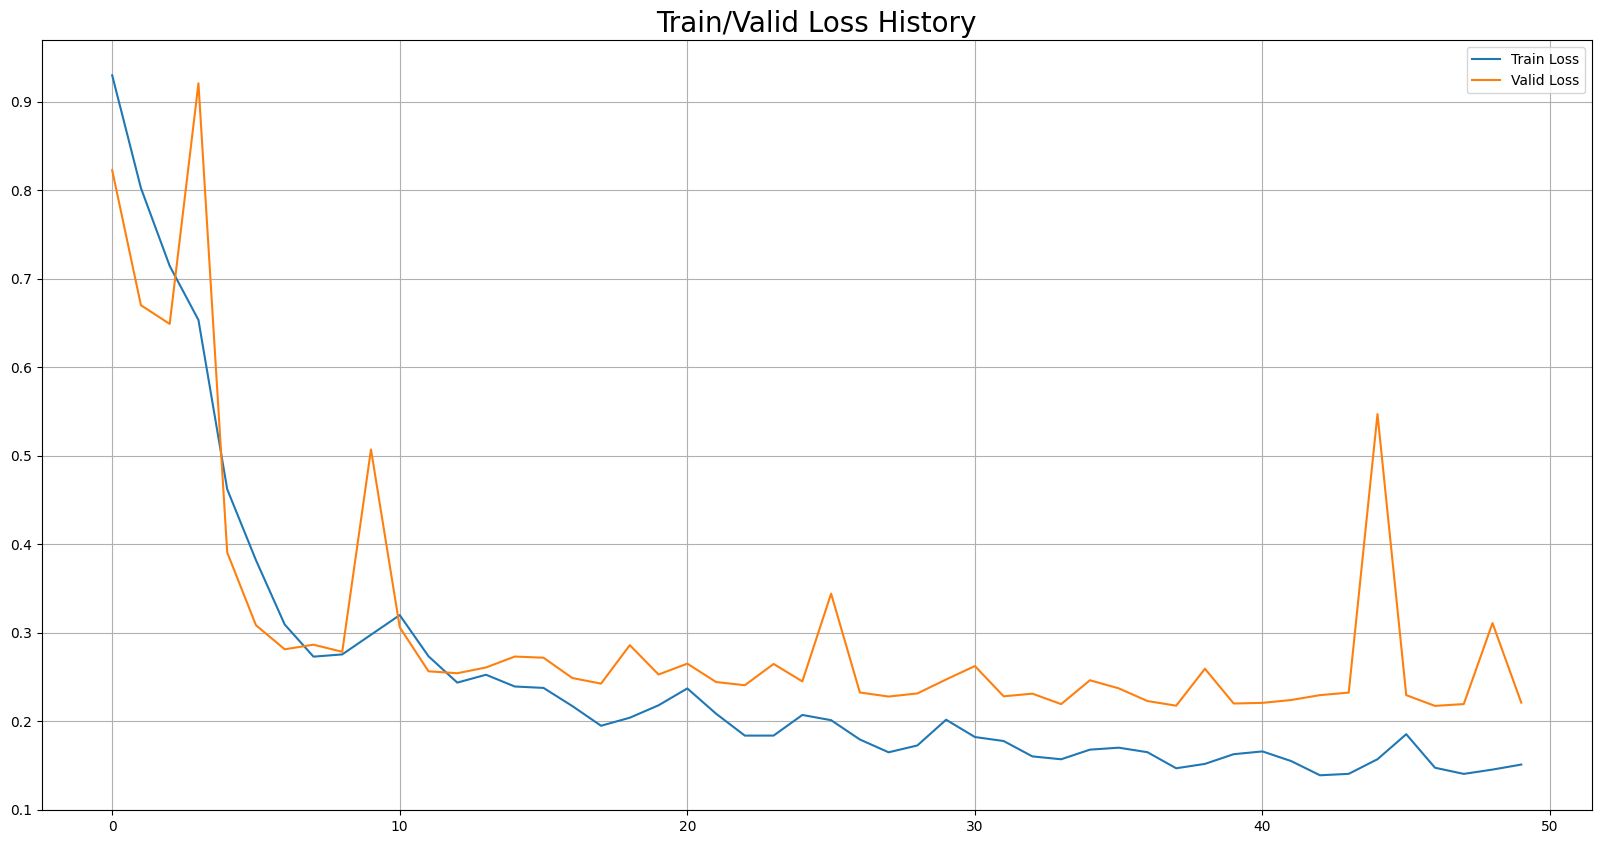

In [41]:
# Train/Valid Loss History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Loss History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Loss'][plot_from:])), 
    result['Train Loss'][plot_from:], 
    label = 'Train Loss'
    )

plt.plot(
    range(0, len(result['Valid Loss'][plot_from:])), 
    result['Valid Loss'][plot_from:], 
    label = 'Valid Loss'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)
plt.show()

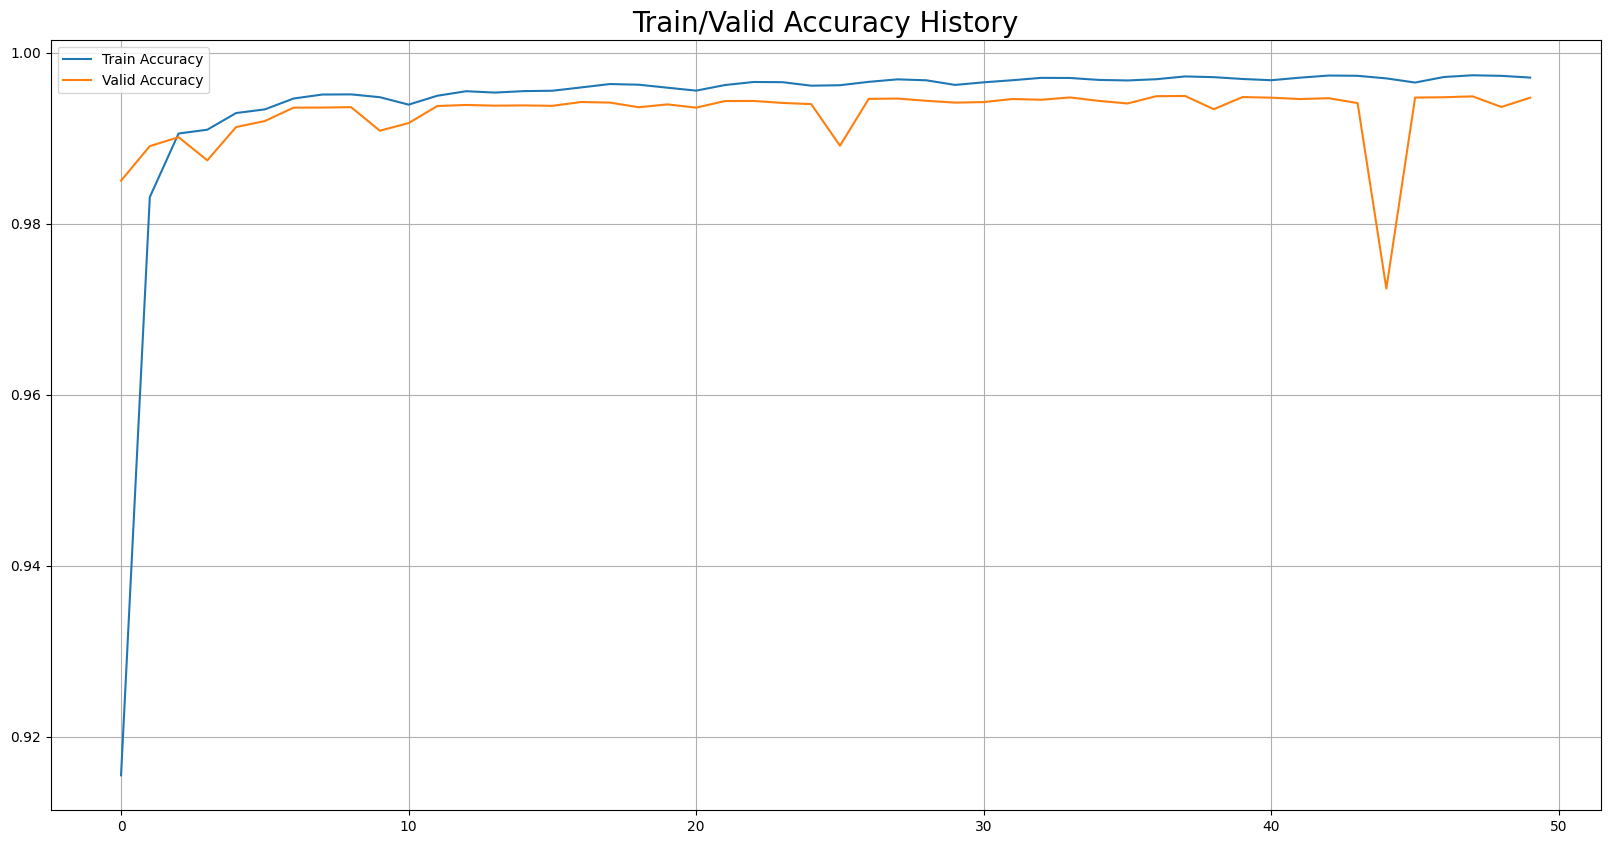

In [42]:
## Train/Valid Accuracy History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Accuracy History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Accuracy'][plot_from:])), 
    result['Train Accuracy'][plot_from:], 
    label = 'Train Accuracy'
    )

plt.plot(
    range(0, len(result['Valid Accuracy'][plot_from:])), 
    result['Valid Accuracy'][plot_from:], 
    label = 'Valid Accuracy'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)


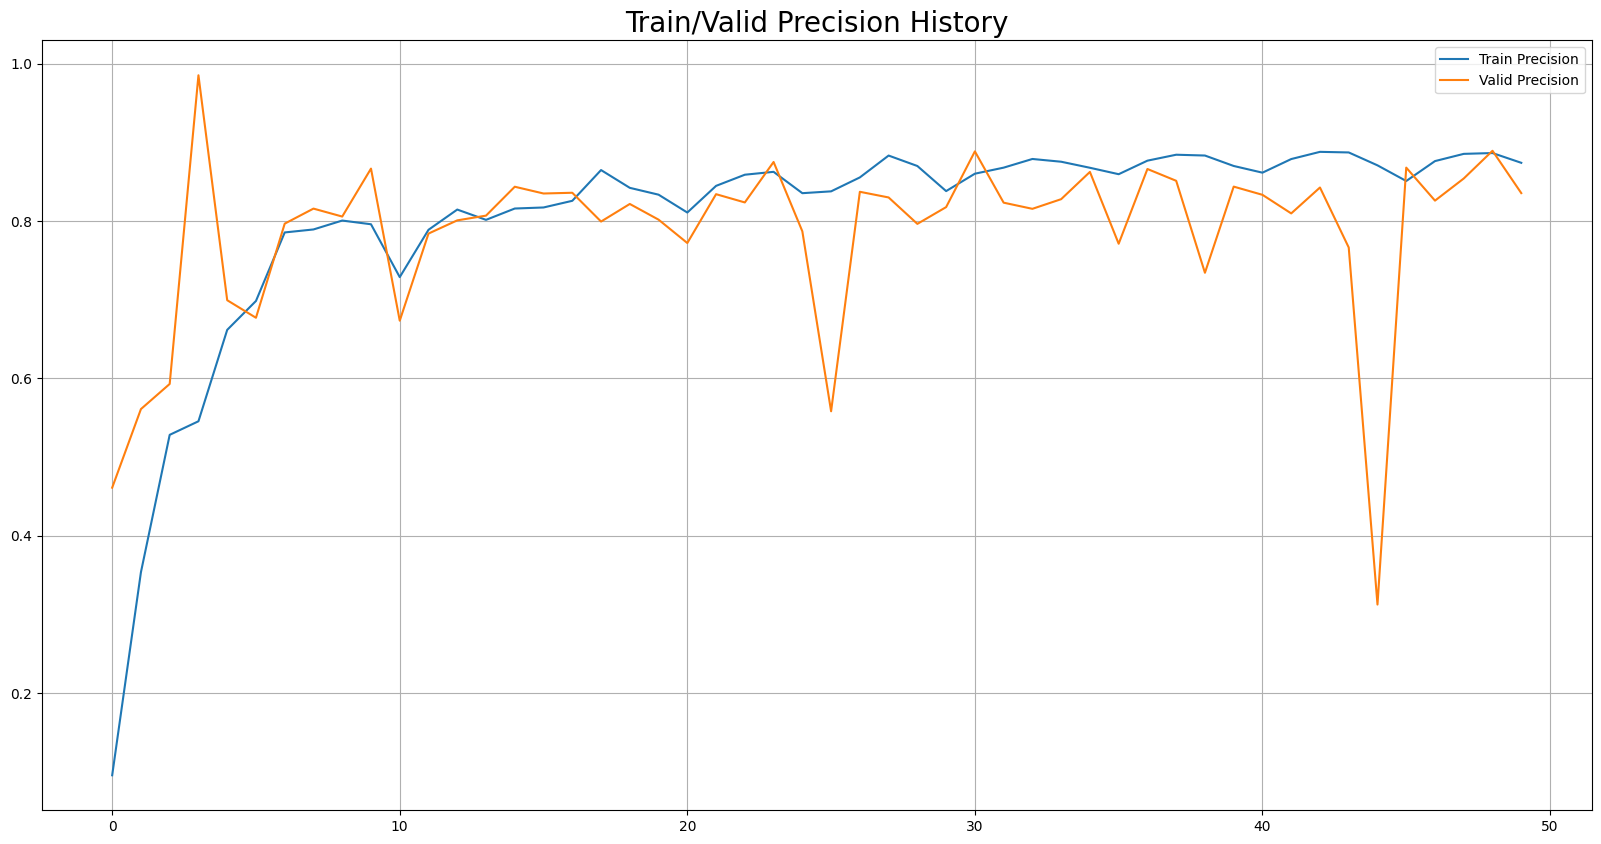

In [43]:
## Train/Valid Precision History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Precision History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Precision'][plot_from:])), 
    result['Train Precision'][plot_from:], 
    label = 'Train Precision'
    )

plt.plot(
    range(0, len(result['Valid Precision'][plot_from:])), 
    result['Valid Precision'][plot_from:], 
    label = 'Valid Precision'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)

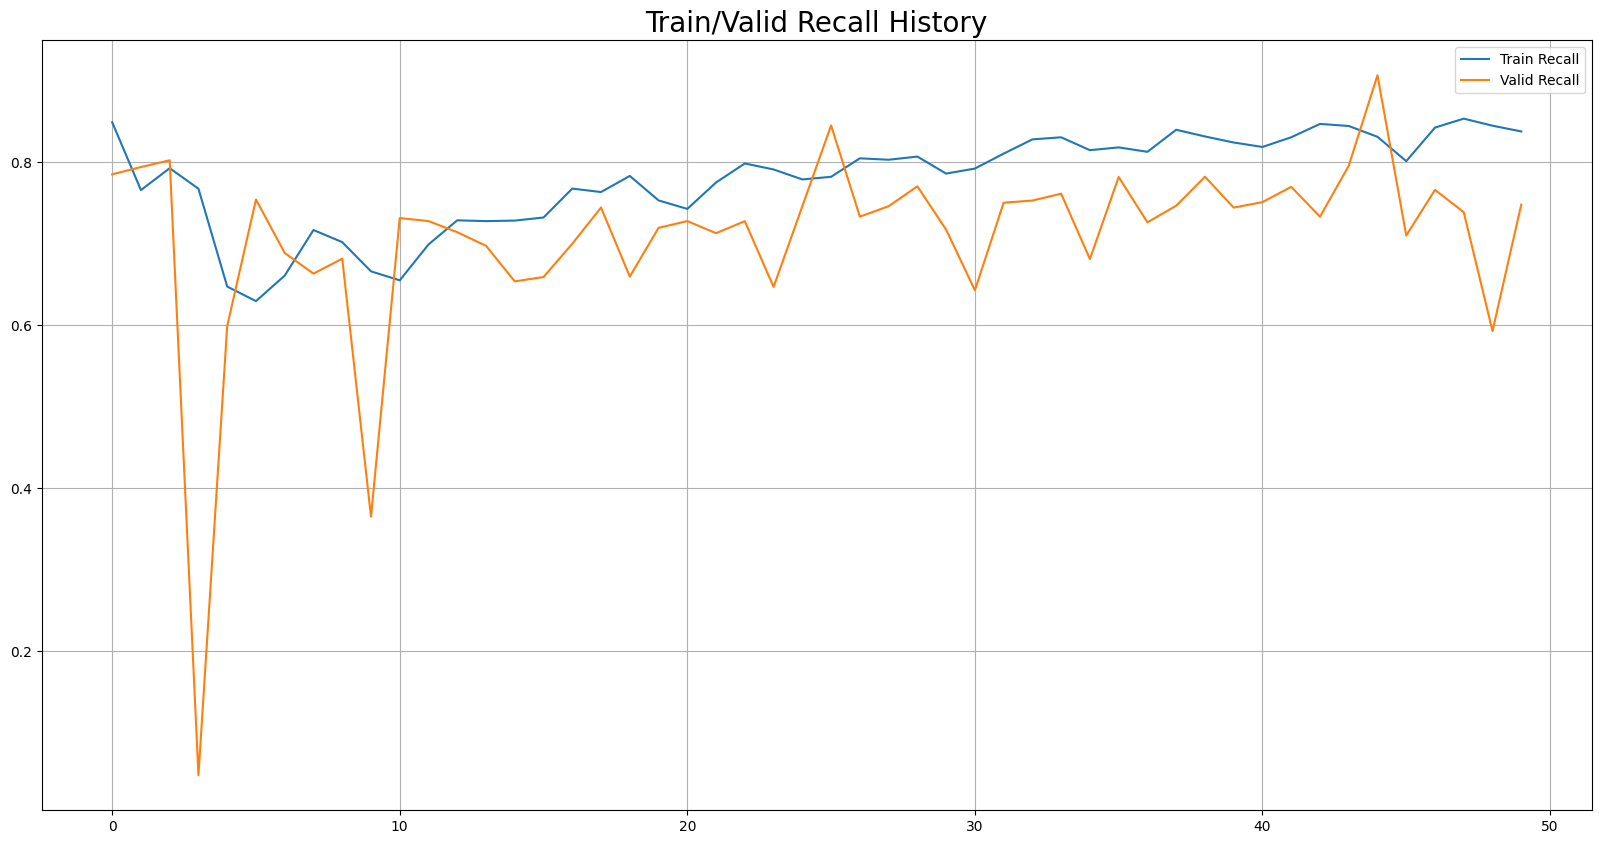

In [44]:
## Train/Valid Recall History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Recall History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Recall'][plot_from:])), 
    result['Train Recall'][plot_from:], 
    label = 'Train Recall'
    )

plt.plot(
    range(0, len(result['Valid Recall'][plot_from:])), 
    result['Valid Recall'][plot_from:], 
    label = 'Valid Recall'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)


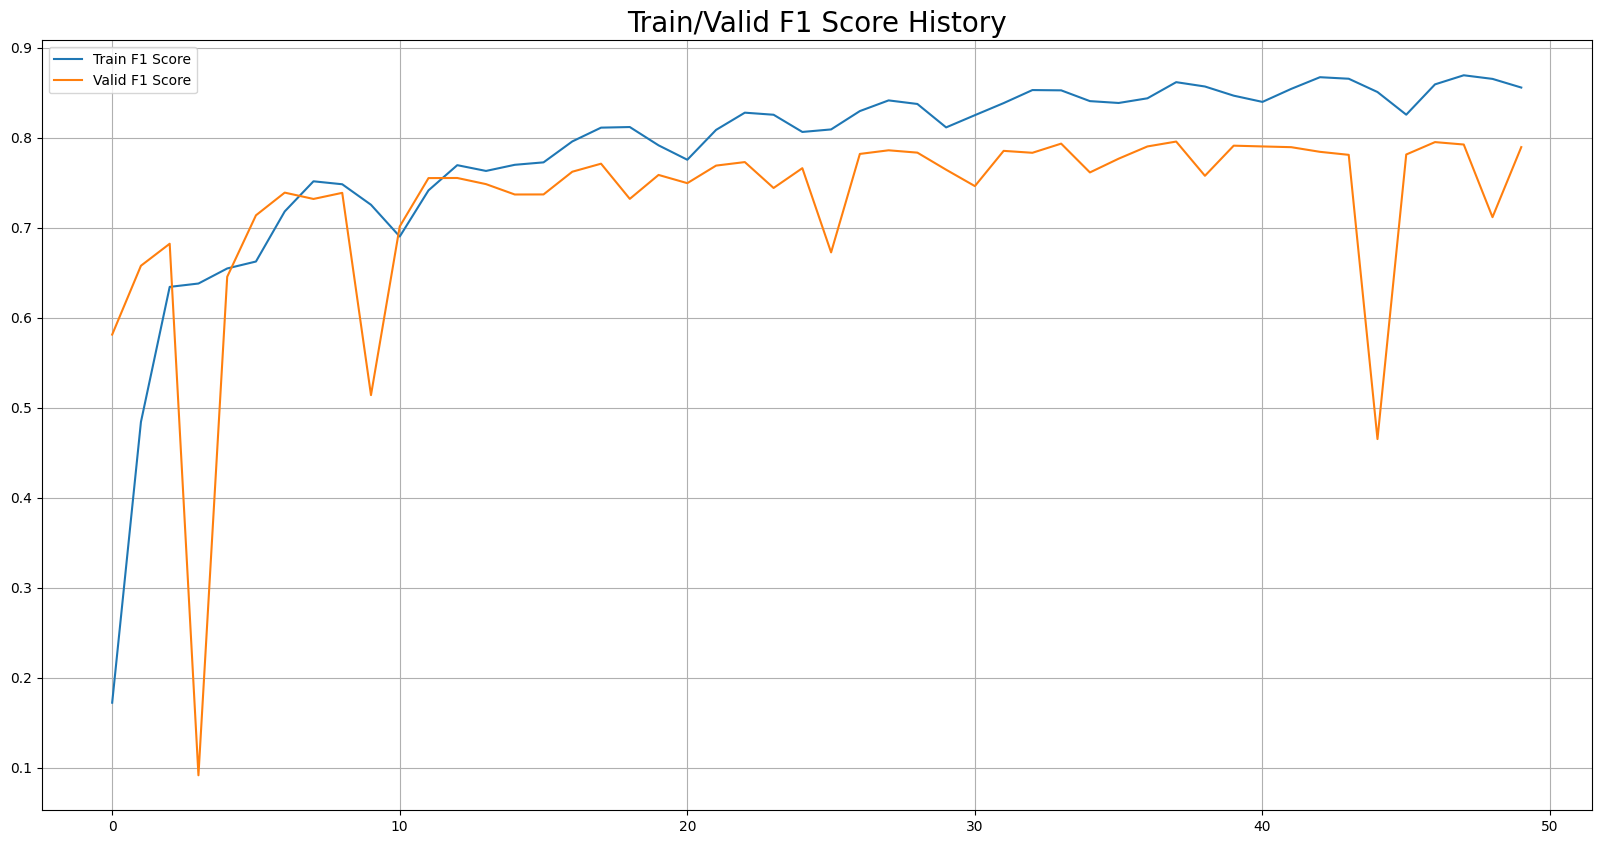

In [45]:
## Train/Valid F1 History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid F1 Score History", fontsize = 20)
plt.plot(
    range(0, len(result['Train F1 Score'][plot_from:])), 
    result['Train F1 Score'][plot_from:], 
    label = 'Train F1 Score'
    )

plt.plot(
    range(0, len(result['Valid F1 Score'][plot_from:])), 
    result['Valid F1 Score'][plot_from:], 
    label = 'Valid F1 Score'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)

# Model Evaluation

In [46]:
# model.load_state_dict(torch.load('/kaggle/working/model.bin'))
model.load_state_dict(torch.load('/kaggle/working/model_f1.bin'))

<All keys matched successfully>

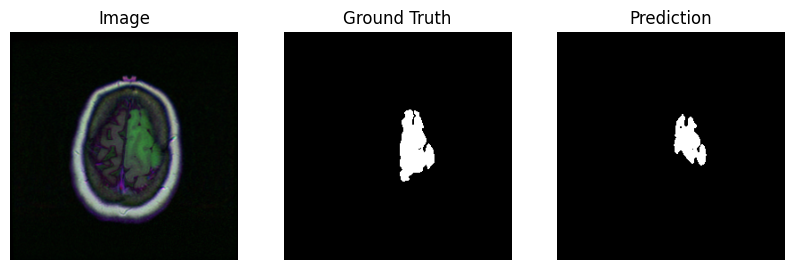

In [48]:
batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))

pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    # Check if the ground truth mask is NOT empty
    if gt_mask.sum() == 0:
        continue  # skip empty masks

    plt.figure(figsize=(10, 5))

    # Image
    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy(), cmap='gray')
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

## Better loss model

In [49]:
# model.load_state_dict(torch.load('/kaggle/working/model.bin'))
model.load_state_dict(torch.load('/kaggle/working/model.bin'))

<All keys matched successfully>

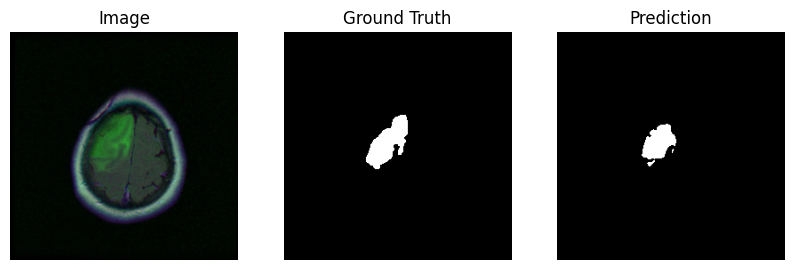

In [50]:
batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))

pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    # Check if the ground truth mask is NOT empty
    if gt_mask.sum() == 0:
        continue  # skip empty masks

    plt.figure(figsize=(10, 5))

    # Image
    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy(), cmap='gray')
    plt.title("Prediction")
    plt.axis("off")

    plt.show()